In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import os
from scipy import signal
from typing import Union, List, Tuple, Dict
from tqdm import tqdm

from cell_inference.config import paths, params
from cell_inference.utils.random_parameter_generator import Random_Parameter_Generator
from cell_inference.utils.transform.geometry_transformation import pol2cart, cart2pol
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid

## Detailed Cell

In [2]:
DATA_PATH = 'cell_inference/resources/detailed'

# model_name = 'neuronal_model_496930324'
model_name = ['neuronal_model_491766131']
detailed_cells_im = []
for name in model_name:
    detailed_cells_im.append(os.path.join(DATA_PATH, name + '_Im.h5'))
#     detailed_cells_im.append(os.path.join(DATA_PATH, name + '_Im_strch.h5'))

## Load configuration

In [3]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, model_name[0]+'_Loc5_restrict_h') # select trial

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp_detailed')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats_detailed')  # summary statistics
# LFP_PATH = os.path.join(TRIAL_PATH, 'lfp_detailed_strch')  # LFP and labels
# STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats_detailed_strch')  # summary statistics

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(DATA_PATH + " not found.")

if not os.path.exists(TRIAL_PATH):
    raise FileNotFoundError(TRIAL_PATH + " not found.")

In [4]:
with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

loc_param_list = ['x','y','z','d','theta','alpha','h','phi']
inference_list = [x for x in config_dict['Trial_Parameters']['inference_list'] if x in loc_param_list]
randomized_list = [x for x in config_dict['Trial_Parameters']['randomized_list'] if x in loc_param_list]

loc_param_list = config_dict['Simulation_Parameters']['loc_param_list']
loc_param_default = config_dict['Simulation_Parameters']['loc_param_default']
loc_param_range = config_dict['Simulation_Parameters']['loc_param_range']
loc_param_dist = config_dict['Simulation_Parameters']['loc_param_dist']

## Generate random samples

In [5]:
number_cells = len(model_name)
number_locs = 100
number_samples = number_cells * number_locs
rand_seed = config_dict['Trial_Parameters']['rand_seed']

rpg = Random_Parameter_Generator(seed=rand_seed, n_sigma=3)

#### Location parameters

In [6]:
loc_param_gen = loc_param_list.copy()
if 'd' in randomized_list and 'theta' in randomized_list:
    loc_param_gen[loc_param_gen.index('x')] = 'd'
    loc_param_gen[loc_param_gen.index('z')] = 'theta'

loc_param_samples = rpg.generate_parameters(number_samples, loc_param_gen, randomized_list, loc_param_default, loc_param_range, loc_param_dist)

if 'd' in randomized_list and 'theta' in randomized_list:
    loc_param_samples['x'], loc_param_samples['z'] = pol2cart(loc_param_samples['d'],loc_param_samples['theta'])

loc_param = np.column_stack([loc_param_samples[key] for key in loc_param_list])

# reshape into ncell-by-nloc-by-2-by-3
loc_param = loc_param.reshape(number_cells, number_locs, 2, 3)

### Get parameters to be inferred as labels

In [7]:
labels = np.column_stack([ loc_param_samples[key] for key in inference_list ]) # TODO: add geometry labels
rand_param = np.column_stack([ loc_param_samples[key] for key in randomized_list[:-len(inference_list)] ])

np.set_printoptions(suppress=True)
print(loc_param.shape)
print(labels.shape)

(1, 100, 2, 3)
(100, 5)


## Simulate LFP

In [8]:
from cell_inference.utils.currents.ecp import EcpMod, EcpCell

Ecp_list = []
for file in detailed_cells_im:
    Ecp_list.append(EcpMod(EcpCell(file=file), params.ELECTRODE_POSITION, min_distance = params.MIN_DISTANCE))

In [9]:
lfp = []
for i, ecp in enumerate(Ecp_list):
    lfp.append(ecp.calc_ecps(move_cell=loc_param[i], move_elec=True))
lfp = np.stack(lfp, axis=0) # (cells x locs x channels x time)
lfp = lfp.reshape((-1,)+lfp.shape[-2:]).transpose((0,2,1)) # -> (samples x channels x time) -> (samples x time x channels)

with h5py.File(file, 'r') as f:
    dt = f.attrs['dt']
    t = np.arange(lfp.shape[1])*dt

## Get LFPs
#### Save what

In [10]:
save_lfp = False
save_stats = True

#### Filter each channel. Get window of spike for each sample.

In [11]:
filt_b, filt_a = signal.butter(params.BUTTERWORTH_ORDER,
                               params.FILTER_CRITICAL_FREQUENCY,
                               params.BANDFILTER_TYPE,
                               fs=params.FILTER_SAMPLING_RATE)

filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=1)  # filter along time axis

lfp_list = []
bad_indices = []
for i in tqdm(range(number_samples)):
#     filtered_lfp[i] /= np.max(np.abs(filtered_lfp[i]))
    try:
        start, end = get_spike_window(filtered_lfp[i], win_size=params.WINDOW_SIZE, align_at=params.PK_TR_IDX_IN_WINDOW) # 24*0.025=0.6 ms
        lfp_list.append(filtered_lfp[i,start:end,:])
    except ValueError:
        bad_indices.append(i)

t = t[:params.WINDOW_SIZE]
windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)
labels = np.delete(labels, bad_indices, axis=0)
print('%d bad samples.' % len(bad_indices))

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 1630.86it/s]

0 bad samples.


In [12]:
if save_stats:
    y_idx = inference_list.index('y') if 'y' in inference_list else None
    summ_stats = []
    bad_indices = []
    yshift = []
    for i in tqdm(range(windowed_lfp.shape[0])):
        try:
            g_lfp, _, y_c = build_lfp_grid(windowed_lfp[i], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
        except ValueError:
            bad_indices.append(i)
            continue
        summ_stats.append(calculate_stats(g_lfp))
        if y_idx is not None:
            yshift.append(y_c - labels[i, y_idx])

    summ_stats = np.array(summ_stats)
    yshift = np.array(yshift)
    print('%d bad samples.' % len(bad_indices))

100%|████████████████████████████████████████| 100/100 [11:12<00:00,  6.72s/it]

0 bad samples.


## Save configurations and simulation data

In [13]:
if save_lfp:
    np.savez(LFP_PATH, t=t, x=windowed_lfp, y=labels, rand_param=rand_param, gmax=None)
if save_stats:
    np.savez(STATS_PATH, t=t, x=summ_stats, y=np.delete(labels, bad_indices, axis=0),
         rand_param=rand_param, gmax=None, ys=yshift, bad_indices=bad_indices)
# np.savez(MEM_VOLT_PATH, v=mem_volt, spk=tspk)

## Verify LFPs
We hand compare the LFP plots generated by our data

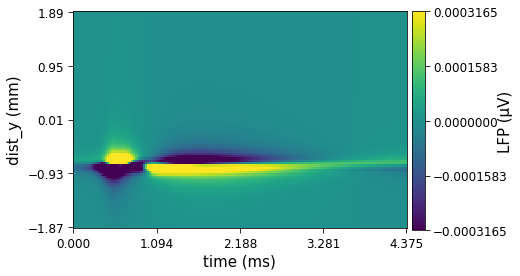

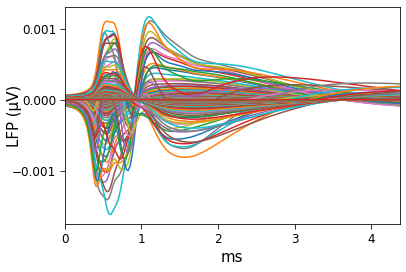

In [14]:
%matplotlib inline

cell_idx = 0

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(params.ELECTRODE_POSITION[:,0])
e_idx = ((params.ELECTRODE_POSITION[:,0]==x_dist[ix]) & 
         (params.ELECTRODE_POSITION[:,1]>=ylim[0]) & 
         (params.ELECTRODE_POSITION[:,1]<=ylim[1]))

_ = plot_lfp_heatmap(t, params.ELECTRODE_POSITION[e_idx, 1],
                              windowed_lfp[cell_idx][:,e_idx], vlim='auto',
                              fontsize=15, labelpad=-10, ticksize=12, tick_length=5, nbins=5)

_ = plot_lfp_traces(t, windowed_lfp[cell_idx], fontsize=15, labelpad=-10, ticksize=12, tick_length=5, nbins=5)